<a href="https://colab.research.google.com/github/mtuan8820/learnNLP/blob/main/POS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import nltk
from nltk.corpus import brown

In [4]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [5]:
corpus = brown.tagged_sents(tagset='universal')

In [6]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [ ]:
len(corpus)

57340

In [7]:
inputs = []
targets = []

for sentence_tag_pairs in corpus:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  inputs.append(tokens)
  targets.append(target)

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, Embedding, GRU, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy



(57340, 25)

In [9]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    inputs,
    targets,
    test_size = 0.3
)

In [10]:
# conver sentences to sequence
MAX_VOCAB_SIZE = None

# capitalization might be usefull, test it later
should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK',
)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [11]:
word2idx = word_tokenizer.word_index
v = len(word2idx)
v

47553

In [12]:
def flatten(list_of_lists):
  return [item for sublist in list_of_lists for item in sublist]

In [13]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [14]:
all_test_targets = set(flatten(test_targets))
all_test_targets == all_train_targets

True

In [15]:
# conver targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [16]:
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max(maxlen_train, maxlen_test)

In [17]:
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
train_inputs_int.shape, test_inputs_int.shape

((40138, 180), (17202, 180))

In [18]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
train_targets_int.shape, test_targets_int.shape

((40138, 180), (17202, 180))

In [19]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

13

In [20]:
D = 32
i = Input(shape = (T,))
x = Embedding(v + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(units=D, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i,x)


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 180, 32)        │      1,521,728 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 180)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 180, 64)        │         16,640 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 180, 13)        │            845 │ bidirectional[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,539,213 (5.87 MB)

 Trainable params: 1,539,213 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
r = model.fit(
    train_inputs_int,
    train_targets_int,
    validation_data=(test_inputs_int, test_targets_int),
    epochs=5,
)

Epoch 1/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 285s 223ms/step - accuracy: 0.0861 - loss: 0.9384 - val_accuracy: 0.1085 - val_loss: 0.1113
Epoch 2/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 278s 221ms/step - accuracy: 0.1096 - loss: 0.0753 - val_accuracy: 0.1091 - val_loss: 0.0906
Epoch 3/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 322s 222ms/step - accuracy: 0.1106 - loss: 0.0447 - val_accuracy: 0.1093 - val_loss: 0.0890
Epoch 4/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 343s 238ms/step - accuracy: 0.1114 - loss: 0.0329 - val_accuracy: 0.1094 - val_loss: 0.0895
Epoch 5/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 300s 221ms/step - accuracy: 0.1116 - loss: 0.0258 - val_accuracy: 0.1093 - val_loss: 0.0937


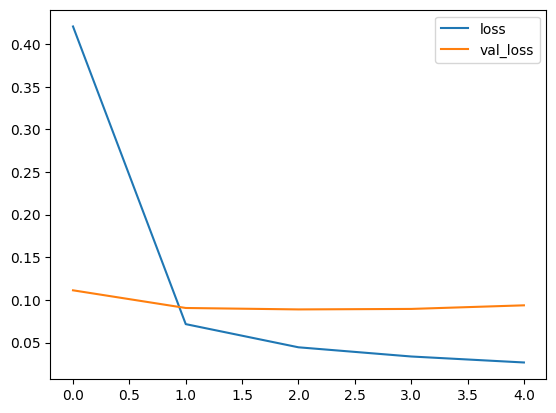

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()


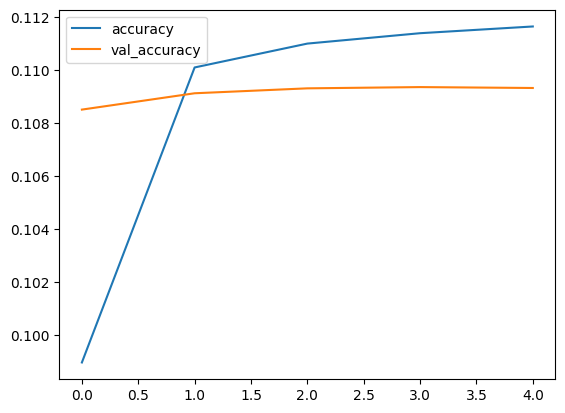

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

In [ ]:
train_probs = model.predict(train_inputs_int)
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  probs = probs[-length:]
  preds = np.argmax(probs, axis=1)
  train_predictions.append(preds)

flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step


In [ ]:
test_probs = model.predict(test_inputs_int)
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

538/538 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print('train acc', accuracy_score(flat_train_targets, flat_train_predictions))
print('test acc', accuracy_score(flat_test_targets, flat_test_predictions))

print('train f1',
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print('test f1',
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))



train acc 0.9937348396273853
test acc 0.9732493782435561
train f1 0.9873934963505734
test f1 0.9345129129213016


In [ ]:
from collections import Counter

def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [ ]:
token2tag = {k: [] for k,v in word2idx.items()}
del token2tag['UNK']

for tokens, tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if should_lowercase:
      token = token.lower()
    if token in token2tag:
      token2tag[token].append(tag)
token2tag = {k: most_common(v) for k,v in token2tag.items()}

In [ ]:
train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
    if should_lowercase:
      token = token.lower()
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [ ]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token,'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [ ]:
print('train acc', accuracy_score(flat_train_targets, flat_train_predictions))
print('test acc', accuracy_score(flat_test_targets, flat_test_predictions))

print('train f1',
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print('test f1',
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))


train acc 0.9937348396273853
test acc 0.9278733773235003
train f1 0.9873934963505734
test f1 0.8231728465384056
